In [1]:
import pandas as pd
from scipy.stats import chi2_contingency, f_oneway, kruskal

# Load the dataset
file_path = '../data/cleaned/final_evaluation.csv'
data = pd.read_csv(file_path)
data.head()

,file,VMONTH,VYEAR,VDAYR,YEAR,AGE,SEX,ETHNIC,RACE,USETOBAC,...,PHYSASST,NPNMW,RNLPN,OTHPROV,MHP,NODISP,REFOTHMD,RETAPPT,OTHDISP,ERADMHOS
0,opd2011.csv,January,2011.0,Monday,2011.0,63.0,Male,Not Hispanic or Latino,White Only,Not current,...,No,No,Yes,No,No,One or more disposition categories marked,No,Yes,No,No
1,opd2011.csv,January,2011.0,Monday,2011.0,72.0,Female,Not Hispanic or Latino,White Only,Not current,...,No,No,Yes,No,No,One or more disposition categories marked,No,Yes,No,No
2,opd2011.csv,January,2011.0,Tuesday,2011.0,77.0,Female,Not Hispanic or Latino,White Only,Not current,...,No,No,Yes,No,No,One or more disposition categories marked,No,Yes,No,No
3,opd2011.csv,January,2011.0,Tuesday,2011.0,27.0,Male,Not Hispanic or Latino,White Only,Current,...,No,Yes,Yes,No,No,One or more disposition categories marked,No,Yes,No,No
4,opd2011.csv,January,2011.0,Wednesday,2011.0,67.0,Male,Not Hispanic or Latino,White Only,Not current,...,No,No,Yes,No,No,One or more disposition categories marked,No,Yes,No,No


In [2]:
import pandas as pd
from scipy.stats import chi2_contingency, f_oneway, kruskal
from scipy.stats import shapiro, levene

# Function to perform chi-square test for categorical variables
def chi_square_test(data, categorical_variable, group_variable):
    contingency_table = pd.crosstab(data[group_variable], data[categorical_variable])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return chi2, p

# Function to perform ANOVA or Kruskal-Wallis test for numerical variables
def anova_or_kruskal(data, numerical_variable, group_variable):
    # Group the numerical variable by the group variable
    groups = [group.dropna().values for name, group in data.groupby(group_variable)[numerical_variable]]
    
    # Test for normality
    normality = all(shapiro(group)[1] > 0.05 for group in groups)
    # Test for homogeneity of variances
    homogeneity = levene(*groups)[1] > 0.05
    
    # If data is normal and variances are homogeneous, perform ANOVA
    if normality and homogeneity:
        stat, p = f_oneway(*groups)
        test_used = 'ANOVA'
    else:
        # Otherwise, perform Kruskal-Wallis test
        stat, p = kruskal(*groups)
        test_used = 'Kruskal-Wallis'
    
    return stat, p, test_used


# Actual variables from the dataset
categorical_variable = 'DIAG1'  
numerical_variable = 'BMI'
group_variable = 'RACE'

# Perform chi-square test
chi2_stat, chi2_p = chi_square_test(data, categorical_variable, group_variable)
print(f"Chi-square test for {categorical_variable} by {group_variable}:")
print(f"Chi-square Statistic: {chi2_stat}, P-value: {chi2_p}\n")

# Perform ANOVA or Kruskal-Wallis test
anova_stat, anova_p, test_used = anova_or_kruskal(data, numerical_variable, group_variable)
print(f"{test_used} test for {numerical_variable} by {group_variable}:")
print(f"Statistic: {anova_stat}, P-value: {anova_p}")

    
        



Chi-square test for DIAG1 by RACE:
Chi-square Statistic: 20677.112967790363, P-value: 1.0765941383215615e-285

Kruskal-Wallis test for BMI by RACE:
Statistic: 101.75378189939282, P-value: 2.2559623619135684e-20


Chi-square test for DIAG1 by RACE:

Chi-square Statistic: 20677.113
P-value: 
1.08
×
1
0
−
285
1.08×10 
−285
 
The chi-square test result shows a very high chi-square statistic and an extremely low p-value. This indicates a statistically significant association between DIAG1 (physician diagnoses) and RACE. In other words, the distribution of diagnoses appears to differ significantly across racial groups.

Kruskal-Wallis test for BMI by RACE:

Statistic: 101.754
P-value: 
2.26
×
1
0
−
20
2.26×10 
−20
 
The Kruskal-Wallis test also shows a statistically significant result with a low p-value. This suggests that there are differences in the distribution of BMI across different racial groups.


The chi-square test implies that race is related to the types of diagnoses given to patients. This might be due to a variety of factors, including but not limited to genetic predispositions, social determinants of health, access to healthcare, or reporting practices.

The Kruskal-Wallis test suggests that the median BMI differs among racial groups. This could reflect differences in lifestyle, socioeconomic status, health awareness, or other factors influencing body mass index.

In [3]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, f_oneway, kruskal, shapiro, levene


# Function to perform chi-square test
def chi_square_test(data, column, group_by):
    contingency_table = pd.crosstab(data[group_by], data[column])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    return chi2, p_value

# Function to perform ANOVA or Kruskal-Wallis test
def anova_kruskal_test(data, column, group_by):
    groups = [group.dropna().values for name, group in data.groupby(group_by)[column]]
    unique_counts = [np.unique(group).size for group in groups]
    
    # Skip the test if there's not enough variation or only one member in a group
    if any(count <= 1 for count in unique_counts):
        return None, None, 'Not enough variation or single member in group'
    
    if all(shapiro(group)[1] > 0.05 for group in groups) and levene(*groups)[1] > 0.05:
        stat, p_value = f_oneway(*groups)
        test_name = 'ANOVA'
    else:
        try:
            stat, p_value = kruskal(*groups)
            test_name = 'Kruskal-Wallis'
        except ValueError as e:
            return None, None, f"Error: {e}"
    
    return stat, p_value, test_name

# Define your alpha level
alpha = 0.05

# Correct alpha for multiple comparisons (Bonferroni correction)
num_tests = len(data.columns) - 1  # subtract 1 for the 'RACE' column
alpha_corrected = alpha / num_tests

# Initialize lists to store significant results
significant_categorical_results = []
significant_numerical_results = []

for column in data.columns:
    if column != 'RACE':  # Exclude comparison with itself
        if data[column].dtype == 'object':  # Assuming categorical
            chi2, p_value = chi_square_test(data, column, 'RACE')
            if p_value is not None and p_value < alpha_corrected:
                significant_categorical_results.append((column, chi2, p_value))
        else:  # Assuming numerical
            stat, p_value, test_used = anova_kruskal_test(data, column, 'RACE')
            if p_value is not None and p_value < alpha_corrected:
                significant_numerical_results.append((column, stat, p_value, test_used))


# Output the results
print("Significant Categorical Variables:")
for result in significant_categorical_results:
    print(f"{result[0]}: Chi2 = {result[1]}, p = {result[2]}")

print("\nSignificant Numerical Variables:")
for result in significant_numerical_results:
    print(f"{result[0]}: {result[3]} Stat = {result[1]}, p = {result[2]}")


Significant Categorical Variables:
VMONTH: Chi2 = 1456.2036996987094, p = 2.159054507602737e-268
VDAYR: Chi2 = 147.66919486708423, p = 1.7336047445243086e-17
SEX: Chi2 = 27.790148837920217, p = 4.0002977478785983e-05
ETHNIC: Chi2 = 1765.5528572159585, p = 0.0
USETOBAC: Chi2 = 70.48107636934454, p = 8.137806861116861e-14
PAYPRIV: Chi2 = 1461.3152819154675, p = 0.0
PAYMCARE: Chi2 = 211.81960485990626, p = 8.391923589005385e-44
PAYMCAID: Chi2 = 1186.1925918627423, p = 2.8754178746736088e-254
PAYSELF: Chi2 = 36.280457939835614, p = 8.34680655542451e-07
PAYNOCHG: Chi2 = 305.3791301317174, p = 6.983959308691953e-64
PAYOTH: Chi2 = 42.292192893486146, p = 5.1404822818942766e-08
PAYDK: Chi2 = 193.06125916716348, p = 8.657104149223193e-40
PAYTYPER: Chi2 = 1831.7676460088933, p = 0.0
INJDET: Chi2 = 164.67360683505012, p = 9.36980779262336e-25
INJURY: Chi2 = 121.4443887605447, p = 1.551509401439854e-24
MAJOR: Chi2 = 229.06619286584132, p = 1.8395970653523653e-37
RFV1: Chi2 = 5653.0899363384315, p 

Significant Categorical Variables
Diagnosis Codes (DIAG1, DIAG2, DIAG3): The chi-square tests show significant associations between diagnosis codes and race. This suggests variability in diagnoses among different racial groups, which could reflect disparities in health conditions, access to healthcare, or diagnostic practices.

Use of Tobacco (USETOBAC), Ethnicity (ETHNIC), and Sex (SEX): These associations indicate differences in demographics and behaviors across racial groups, which could be important for targeted public health interventions.
Payment Methods (PAYPRIV, PAYMCARE, PAYMCAID, etc.): Significant differences in how medical services are paid for among races might reflect socioeconomic disparities or differences in insurance coverage.

Reasons for Visit (RFV1, RFV2, RFV3): The reasons patients visit medical facilities vary significantly with race, potentially indicating differences in health needs, awareness, or availability of services.

Medications (MED1, MED2, etc.): Variability in prescribed medications across racial groups could reflect differences in treatment practices or underlying health conditions.

Significant Numerical Variables

Physiological Measures (AGE, HTIN, WTLB, BMI, BPSYS, BPDIAS): The Kruskal-Wallis tests suggest differences in basic physiological measures across racial groups. These differences could be due to genetic factors, lifestyle, socioeconomic status, or health disparities.

Total Number of Chronic Conditions (TOTCHRON): The significant result indicates variations in the burden of chronic diseases among different racial groups, underscoring the need for targeted healthcare interventions.

Number of New and Continuing Medications (NUMNEW, NUMCONT): This could reflect differences in healthcare needs, access to medical care, or prescribing practices among racial groups.

In [4]:
import pandas as pd
import numpy as np



# Assuming 'data' contains all the relevant variables
# One-hot encode selected categorical variables (simplifying for the example)
# For more complex variables like DIAG1, you might aggregate or select subcategories
categorical_vars = ['SEX', 'USETOBAC', 'ETHNIC']  # Simplified for the example
data_encoded = pd.get_dummies(data[categorical_vars])

# Combine encoded categorical data with numerical variables
numerical_vars = ['AGE', 'HTIN', 'WTLB', 'BMI', 'BPSYS', 'BPDIAS', 'TOTCHRON', 'NUMNEW', 'NUMCONT']
combined_data = pd.concat([data[numerical_vars], data_encoded], axis=1)

# Drop any rows with NaN values for simplicity
combined_data.dropna(inplace=True)




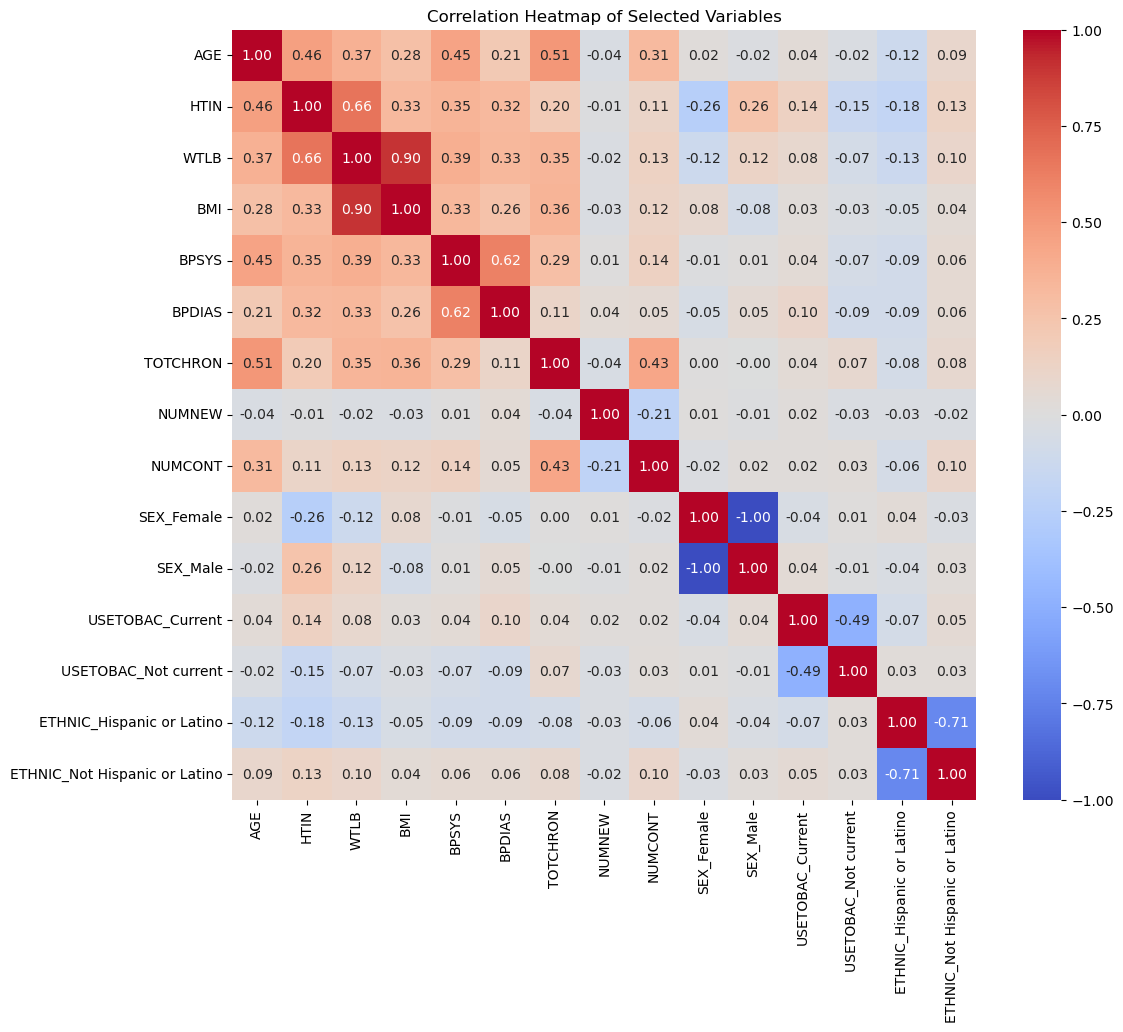

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
corr_matrix = combined_data.corr()

# Generate a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap of Selected Variables')
plt.show()


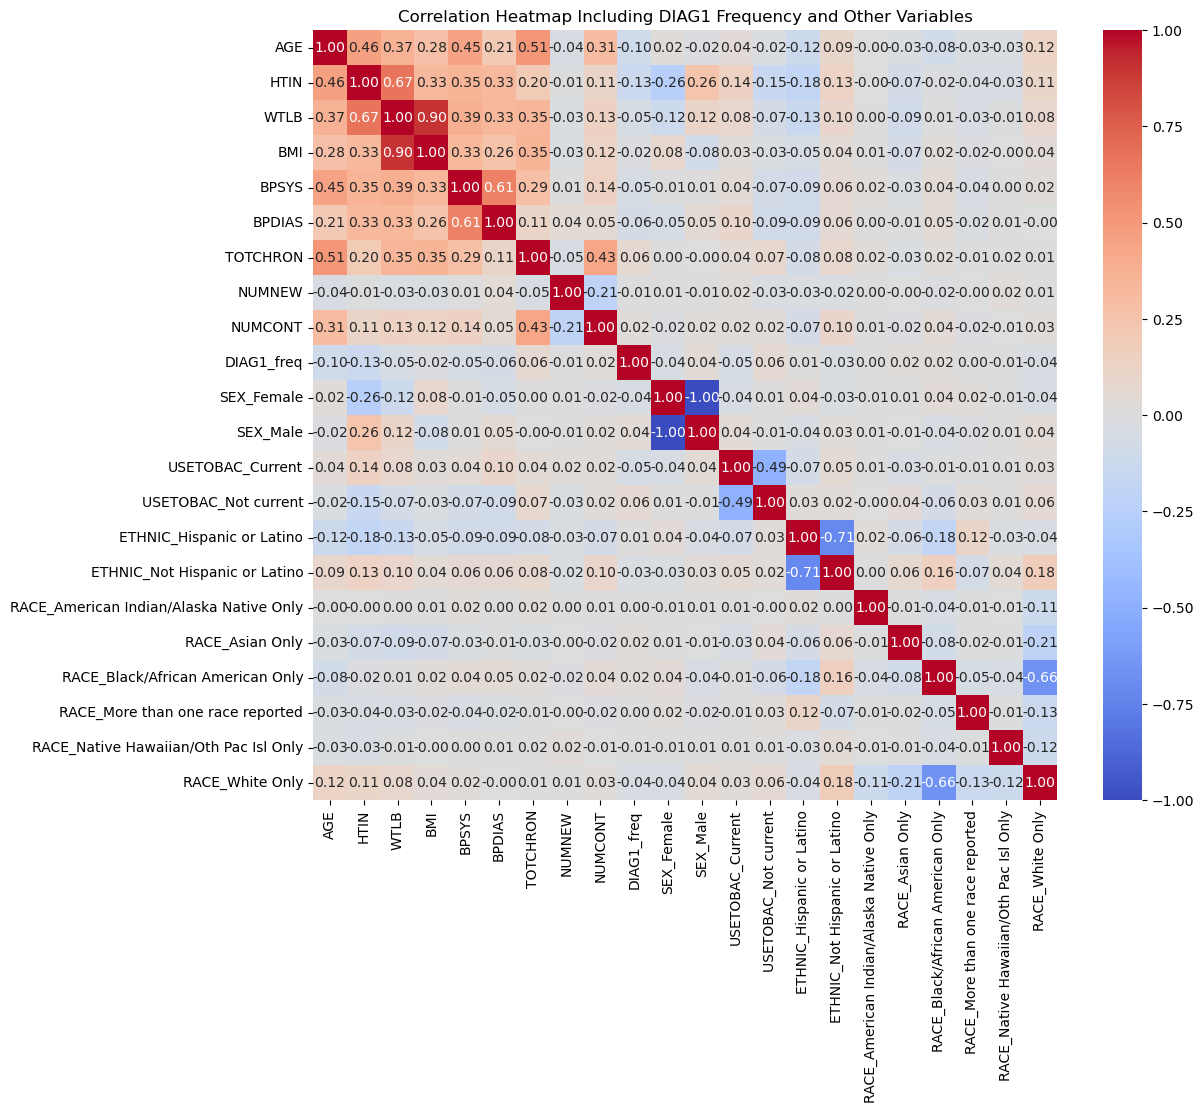

In [6]:
import pandas as pd



# Frequency encoding
frequency = data['DIAG1'].value_counts().to_dict()
data['DIAG1_freq'] = data['DIAG1'].map(frequency)
categorical_vars = ['SEX', 'USETOBAC', 'ETHNIC','RACE']  # Simplified for the example
data_encoded = pd.get_dummies(data[categorical_vars])
numerical_vars = ['AGE', 'HTIN', 'WTLB', 'BMI', 'BPSYS', 'BPDIAS', 'TOTCHRON', 'NUMNEW', 'NUMCONT', 'DIAG1_freq']
combined_data = pd.concat([data[numerical_vars], data_encoded], axis=1)

# Drop any rows with NaN values for simplicity
combined_data.dropna(inplace=True)

corr_matrix = combined_data.corr()

# Generate the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap Including DIAG1 Frequency and Other Variables')
plt.show()

# Now, 'DIAG1_freq' is a numerical column that can be included in correlation analysis


Diverse Conditions: DIAG1 likely includes a wide range of medical conditions, many of which may not have a direct or strong relationship with BMI. The overall frequency encoding method dilutes specific relationships because it aggregates all diagnoses into a single numerical value.
BMI Variability: BMI can vary significantly across individuals for reasons unrelated to the most common diagnoses captured by DIAG1_freq. Factors affecting BMI include genetics, diet, physical activity levels, and other health conditions not directly captured by the most frequent diagnosis codes.

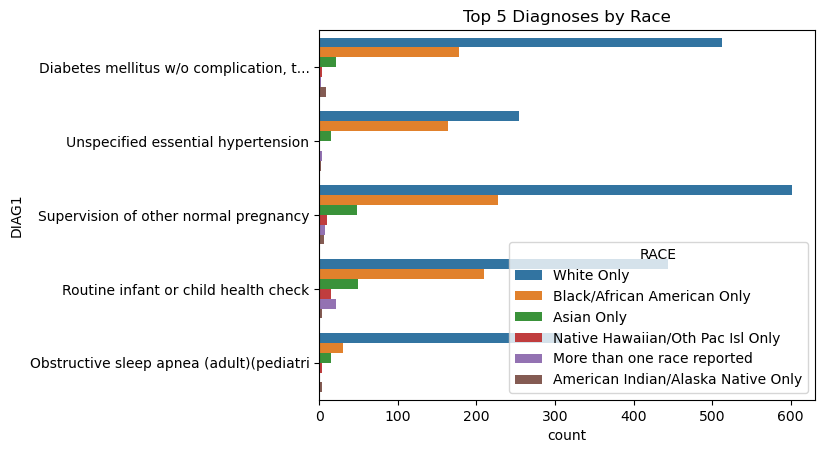

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt 
top_diagnoses = data['DIAG1'].value_counts().index[:5]
sns.countplot(y='DIAG1', hue='RACE', data=data[data['DIAG1'].isin(top_diagnoses)])
plt.title('Top 5 Diagnoses by Race')
plt.show()


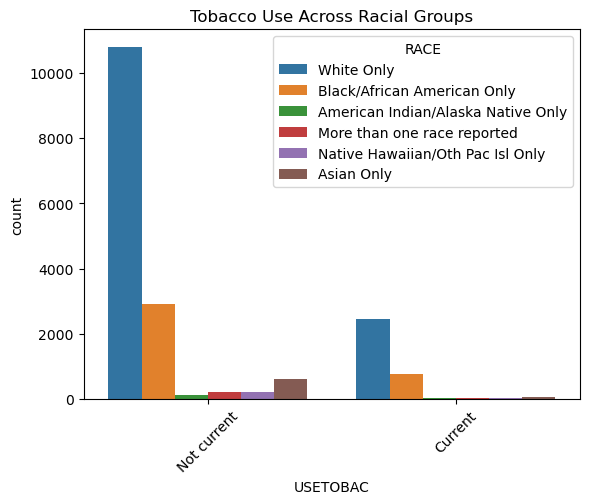

In [8]:
# Example: Compare tobacco use across races
sns.countplot(x='USETOBAC', hue='RACE', data=data)
plt.title('Tobacco Use Across Racial Groups')
plt.xticks(rotation=45)
plt.show()


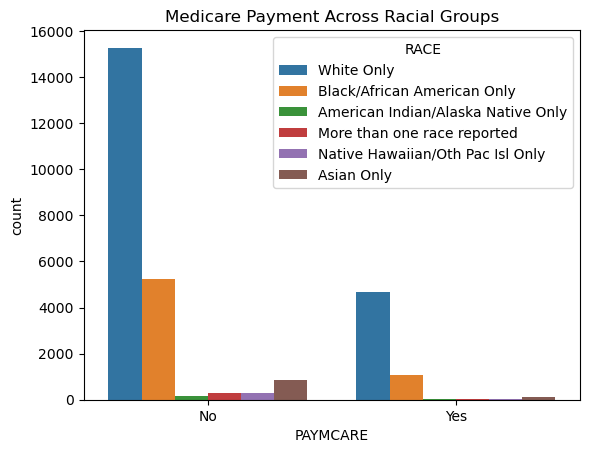

In [9]:
# Example: Visualization of payment method preference by race for Medicare
sns.countplot(x='PAYMCARE', hue='RACE', data=data)
plt.title('Medicare Payment Across Racial Groups')
plt.show()


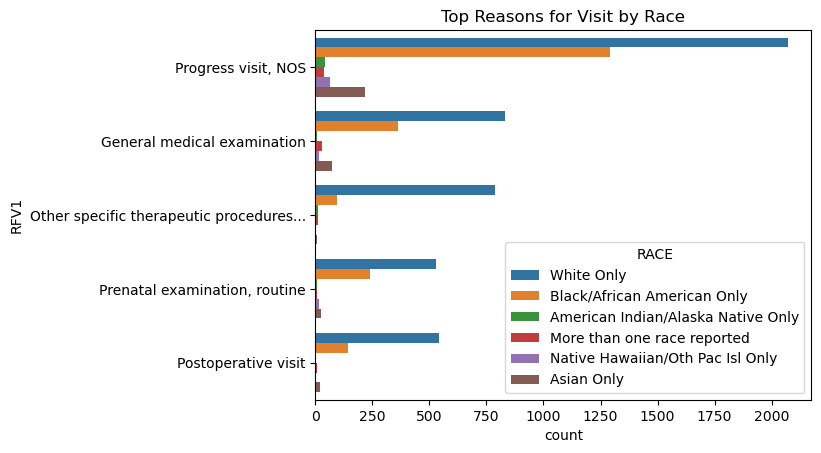

In [10]:
# Example: Analyzing the first reason for visit across racial groups
sns.countplot(y='RFV1', hue='RACE', data=data, order=data['RFV1'].value_counts().iloc[:5].index)
plt.title('Top Reasons for Visit by Race')
plt.show()


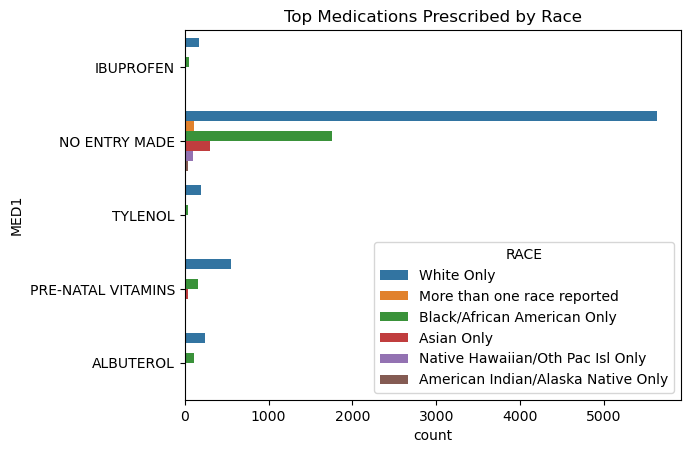

In [11]:
# Example: Top prescribed medications (MED1) across racial groups
top_meds = data['MED1'].value_counts().index[:5]
sns.countplot(y='MED1', hue='RACE', data=data[data['MED1'].isin(top_meds)])
plt.title('Top Medications Prescribed by Race')
plt.show()


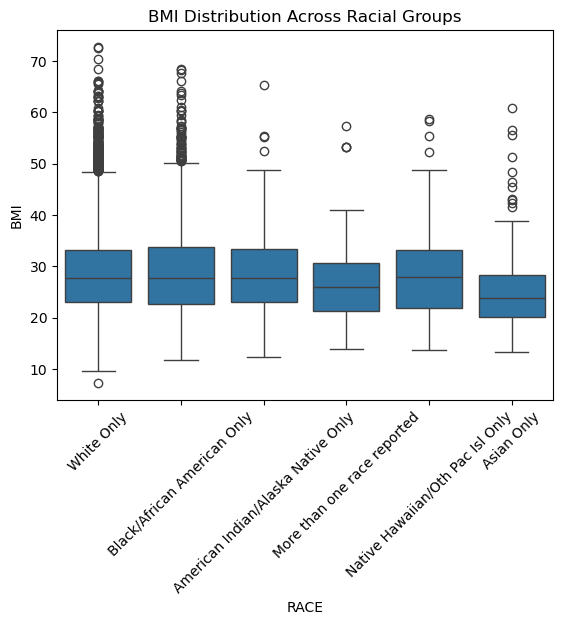

In [12]:
# Example: Distribution of BMI across racial groups
sns.boxplot(x='RACE', y='BMI', data=data)
plt.title('BMI Distribution Across Racial Groups')
plt.xticks(rotation=45)
plt.show()


In [13]:
import pandas as pd
from scipy.stats import chi2_contingency, f_oneway, kruskal
from scipy.stats import shapiro, levene

# Function to perform chi-square test for categorical variables
def chi_square_test(data, categorical_variable, group_variable):
    contingency_table = pd.crosstab(data[group_variable], data[categorical_variable])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return chi2, p

# Function to perform ANOVA or Kruskal-Wallis test for numerical variables
def anova_or_kruskal(data, numerical_variable, group_variable):
    # Group the numerical variable by the group variable
    groups = [group.dropna().values for name, group in data.groupby(group_variable)[numerical_variable]]
    
    # Test for normality
    normality = all(shapiro(group)[1] > 0.05 for group in groups)
    # Test for homogeneity of variances
    homogeneity = levene(*groups)[1] > 0.05
    
    # If data is normal and variances are homogeneous, perform ANOVA
    if normality and homogeneity:
        stat, p = f_oneway(*groups)
        test_used = 'ANOVA'
    else:
        # Otherwise, perform Kruskal-Wallis test
        stat, p = kruskal(*groups)
        test_used = 'Kruskal-Wallis'
    
    return stat, p, test_used


# Actual variables from the dataset
categorical_variable = 'DIAG1'  
numerical_variable = 'BMI'
group_variable = 'RACE'

# Perform chi-square test
chi2_stat, chi2_p = chi_square_test(data, categorical_variable, group_variable)
print(f"Chi-square test for {categorical_variable} by {group_variable}:")
print(f"Chi-square Statistic: {chi2_stat}, P-value: {chi2_p}\n")

# Perform ANOVA or Kruskal-Wallis test
anova_stat, anova_p, test_used = anova_or_kruskal(data, numerical_variable, group_variable)
print(f"{test_used} test for {numerical_variable} by {group_variable}:")
print(f"Statistic: {anova_stat}, P-value: {anova_p}")

Chi-square test for DIAG1 by RACE:
Chi-square Statistic: 20677.112967790363, P-value: 1.0765941383215615e-285

Kruskal-Wallis test for BMI by RACE:
Statistic: 101.75378189939282, P-value: 2.2559623619135684e-20


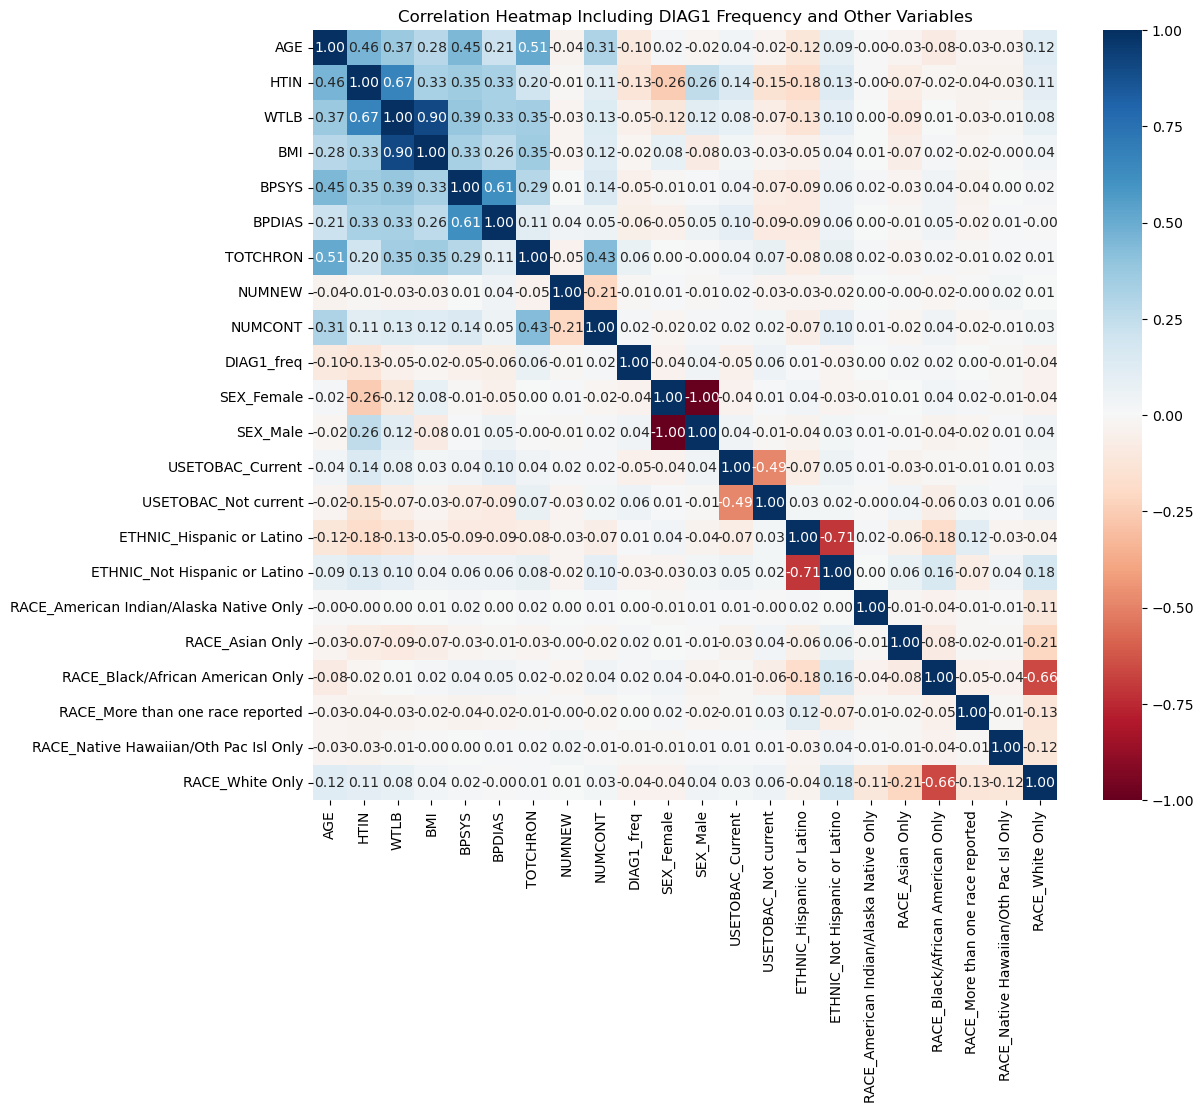

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Assuming 'data' contains all the relevant variables
# One-hot encode selected categorical variables (simplifying for the example)
# For more complex variables like DIAG1, you might aggregate or select subcategories
categorical_vars = ['SEX', 'USETOBAC', 'ETHNIC']  # Simplified for the example
data_encoded = pd.get_dummies(data[categorical_vars])

# Combine encoded categorical data with numerical variables
numerical_vars = ['AGE', 'HTIN', 'WTLB', 'BMI', 'BPSYS', 'BPDIAS', 'TOTCHRON', 'NUMNEW', 'NUMCONT']
combined_data = pd.concat([data[numerical_vars], data_encoded], axis=1)

# Drop any rows with NaN values for simplicity
combined_data.dropna(inplace=True)


# Frequency encoding
frequency = data['DIAG1'].value_counts().to_dict()
data['DIAG1_freq'] = data['DIAG1'].map(frequency)
categorical_vars = ['SEX', 'USETOBAC', 'ETHNIC','RACE']  # Simplified for the example
data_encoded = pd.get_dummies(data[categorical_vars])
numerical_vars = ['AGE', 'HTIN', 'WTLB', 'BMI', 'BPSYS', 'BPDIAS', 'TOTCHRON', 'NUMNEW', 'NUMCONT', 'DIAG1_freq']
combined_data = pd.concat([data[numerical_vars], data_encoded], axis=1)

# Drop any rows with NaN values for simplicity
combined_data.dropna(inplace=True)

corr_matrix = combined_data.corr()

# Generate the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='RdBu', cbar=True)
plt.title('Correlation Heatmap Including DIAG1 Frequency and Other Variables')
plt.show()

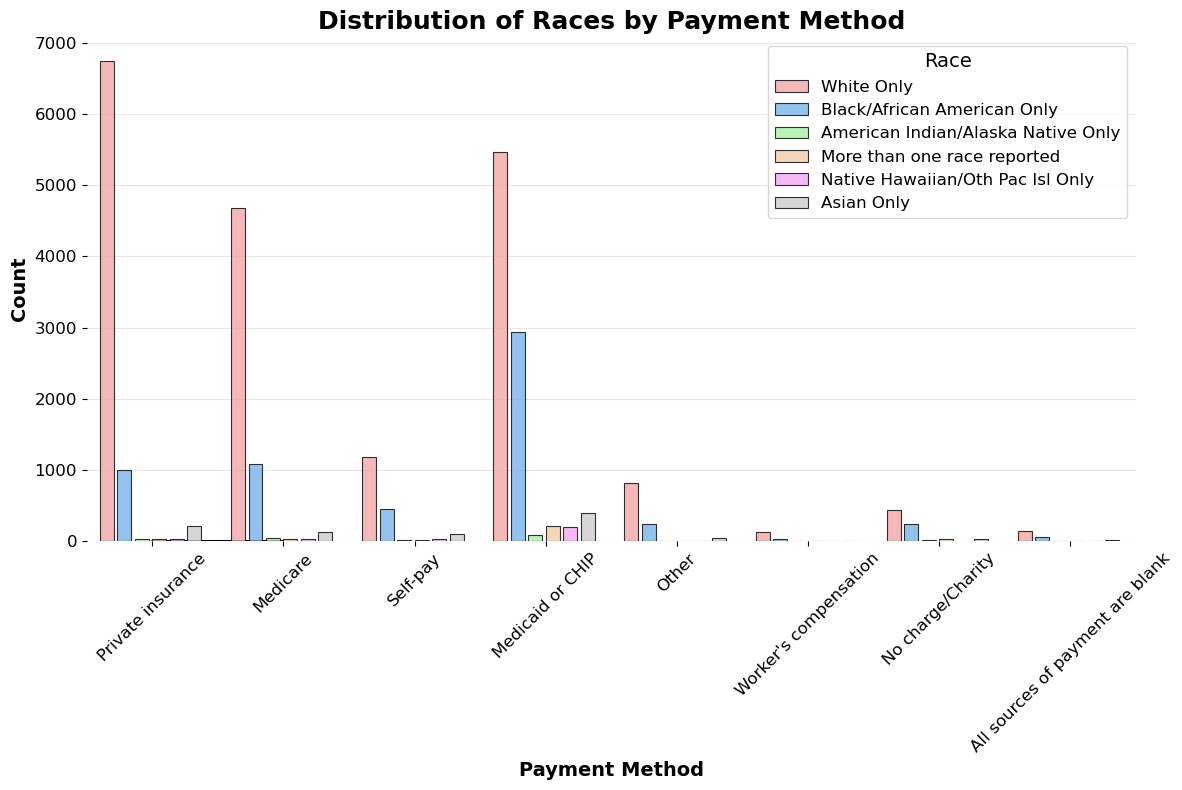

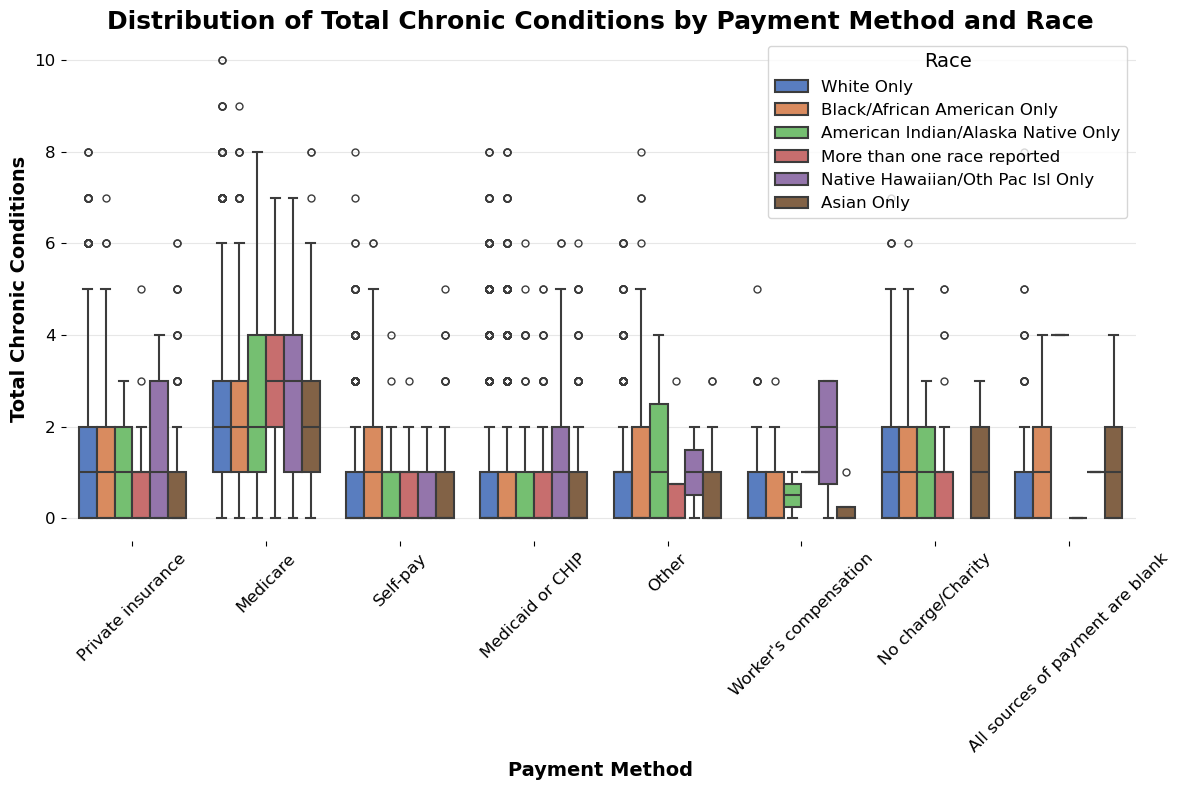

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import PathPatch
from matplotlib.path import Path


# Set a custom color palette
colors = ['#FF9999', '#66B3FF', '#99FF99', '#FFCC99', '#FF99FF', '#CCCCCC']
sns.set_palette(colors)

# Stacked Bar Chart: Distribution of Races by Payment Method
plt.figure(figsize=(12, 8))
ax = sns.countplot(data=data, x='PAYTYPER', hue='RACE', alpha=0.8, dodge=True, edgecolor='black', linewidth=0.8)

for bar in ax.patches:
    bar.set_width(bar.get_width() * 0.8)  # Adjust the width of the bars
    bar.set_edgecolor('black')  # Set the edge color to black
    bar.set_linewidth(0.8)  # Set the line width of the edges
    bar.set_alpha(0.8)  # Set the transparency of the bars
    bar.set_zorder(2)  # Set the z-order to bring the bars in front of the grid

    # Create rounded corners for the bars
    vertices = bar.get_path().vertices
    codes = bar.get_path().codes
    codes = codes.tolist()
    codes += [Path.LINETO, Path.CLOSEPOLY]
    vertices = vertices.tolist()
    vertices += [(vertices[-1][0], 0), (vertices[0][0], 0)]

    radius = 50  # Adjust the radius to control the roundness of the corners
    path = Path(vertices, codes)
    patch = PathPatch(path, edgecolor='black', facecolor=bar.get_facecolor(), linewidth=0.8)
    ax.add_patch(patch)

plt.xlabel('Payment Method', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.title('Distribution of Races by Payment Method', fontsize=18, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Race', fontsize=12, title_fontsize=14)
plt.grid(axis='y', alpha=0.3, zorder=1)  # Set the z-order of the grid to be behind the bars
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

# Box Plot: Distribution of Total Chronic Conditions by Payment Method and Race
sns.set_palette(sns.color_palette("muted"))
plt.figure(figsize=(12, 8))
sns.boxplot(data=data, x='PAYTYPER', y='TOTCHRON', hue='RACE', linewidth=1.5, fliersize=5)
plt.xlabel('Payment Method', fontsize=14, fontweight='bold')
plt.ylabel('Total Chronic Conditions', fontsize=14, fontweight='bold')
plt.title('Distribution of Total Chronic Conditions by Payment Method and Race',
          fontsize=18, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Race', fontsize=12, title_fontsize=14)
plt.grid(axis='y', alpha=0.3)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

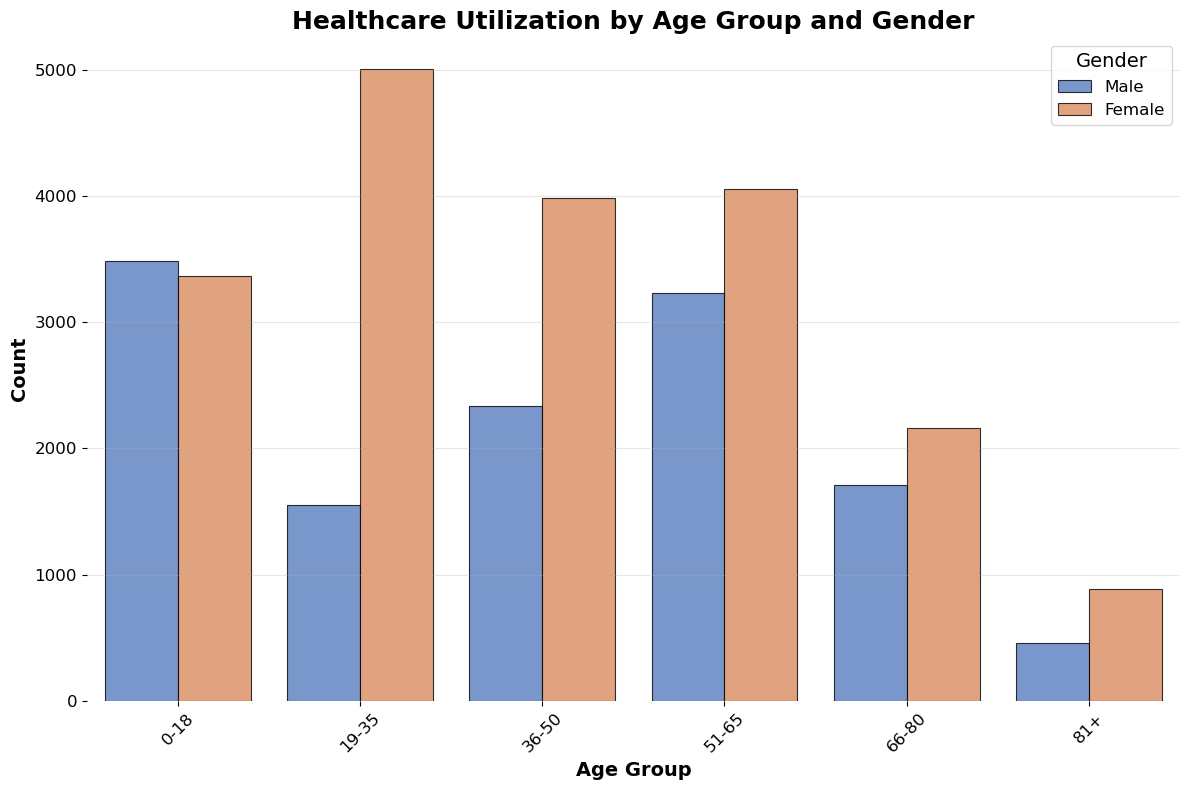

/var/folders/c8/pnw7bntx7x114gfq6xt8lwrw0000gn/T/ipykernel_34067/2024060809.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  utilization_data = data.groupby(['AGE_GROUP', 'PAYTYPER']).size().unstack()


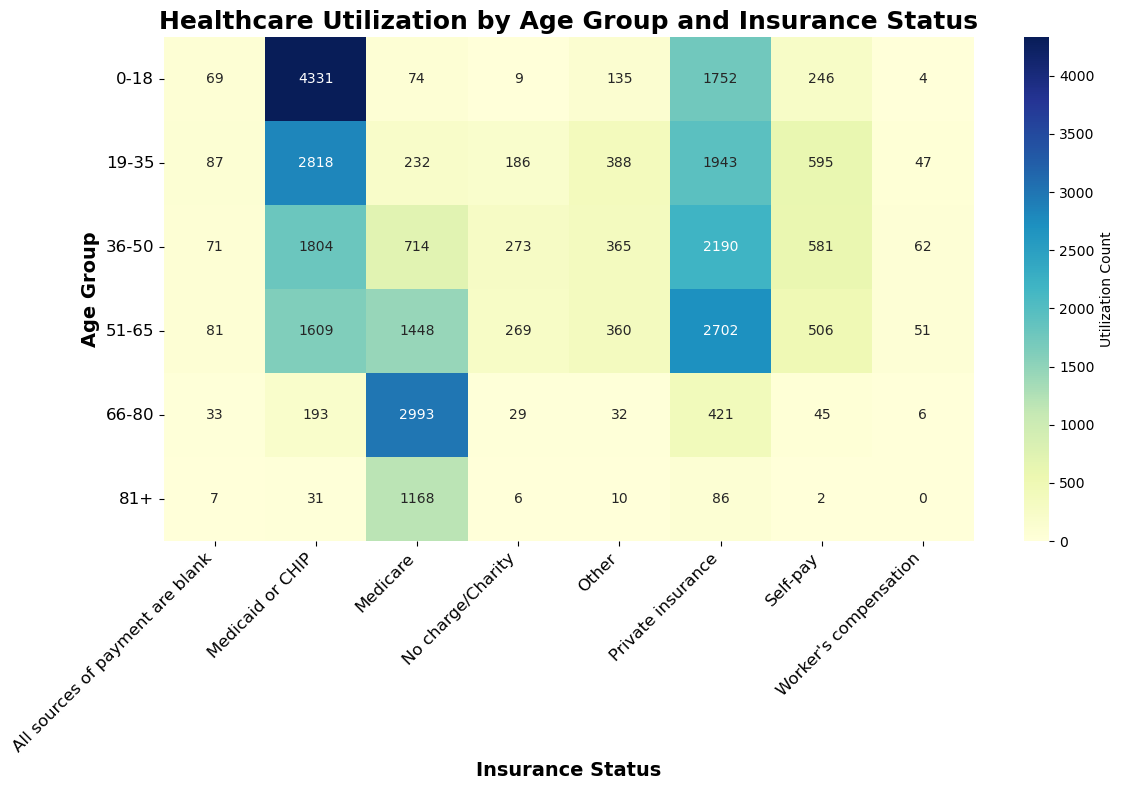

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns



# Create age groups
data['AGE_GROUP'] = pd.cut(data['AGE'], bins=[0, 18, 35, 50, 65, 80, 100], 
                           labels=['0-18', '19-35', '36-50', '51-65', '66-80', '81+'])

# Stacked Bar Chart: Healthcare Utilization by Age Group and Gender
plt.figure(figsize=(12, 8))
ax = sns.countplot(data=data, x='AGE_GROUP', hue='SEX', alpha=0.8, edgecolor='black', linewidth=0.8)

plt.xlabel('Age Group', fontsize=14, fontweight='bold')
plt.ylabel('Count', fontsize=14, fontweight='bold')
plt.title('Healthcare Utilization by Age Group and Gender', fontsize=18, fontweight='bold')
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Gender', fontsize=12, title_fontsize=14)
plt.grid(axis='y', alpha=0.3)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

# Heatmap: Healthcare Utilization by Age Group and Insurance Status
utilization_data = data.groupby(['AGE_GROUP', 'PAYTYPER']).size().unstack()
utilization_data = utilization_data.fillna(0)

plt.figure(figsize=(12, 8))
sns.heatmap(utilization_data, cmap='YlGnBu', annot=True, fmt='d', cbar_kws={'label': 'Utilization Count'})

plt.xlabel('Insurance Status', fontsize=14, fontweight='bold')
plt.ylabel('Age Group', fontsize=14, fontweight='bold')
plt.title('Healthcare Utilization by Age Group and Insurance Status', fontsize=18, fontweight='bold')
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()